In [ ]:
# !pip install keplergl

In [3]:
!pip install prophet

In [101]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import folium
from folium.plugins import HeatMap, HeatMapWithTime
from IPython.display import display, HTML
from scipy.stats import percentileofscore
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
# import requests

# Ignore all warnings
warnings.filterwarnings('ignore')
# Adjust display options for pandas
pd.set_option('display.max_columns', 100)  # Show all columns
# Setting a professional style
sns.set_theme(style="dark")

In [5]:
from google.colab import output
output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# **1. EDA**

In [ ]:
'''
1. Find and remove anomalies (age, starttime > endtime, too long duration >24h, )
2. density based heatmap by hour of the day, year etc
3. analyze the seasonality and trend and make prediction of usage
4. clustering?
5. recommendation and promotions based on the clusters
'''

## **1.1 Import Data**

In [6]:
def describe_data(df):
    summary = {}

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):  # Continuous variables
            summary[col] = {
                'Type': 'Continuous',
                'Count': df[col].count(),
                'Mean': df[col].mean(),
                'Median': df[col].median(),
                'Std': df[col].std(),
                'Min': df[col].min(),
                '25%': df[col].quantile(0.25),
                '50%': df[col].quantile(0.50),
                '75%': df[col].quantile(0.75),
                'Max': df[col].max(),
            }
        elif pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object:  # Categorical variables
            summary[col] = {
                'Type': 'Categorical',
                'Count': df[col].count(),
                'Unique': df[col].nunique(),
                'Top': df[col].mode()[0] if not df[col].mode().empty else None,
                'Freq': df[col].value_counts().iloc[0] if not df[col].value_counts().empty else None
            }

    return pd.DataFrame(summary).T

### **1.1.1 Load citibike trip sample**

In [7]:
citibike_trip_sample_df = pd.read_csv('citibike-trips-sample.csv')
citibike_trip_sample_df['starttime'] = pd.to_datetime(citibike_trip_sample_df['starttime'])
citibike_trip_sample_df['start_hour'] = citibike_trip_sample_df['starttime'].dt.hour
citibike_trip_sample_df['start_month'] = citibike_trip_sample_df['starttime'].dt.month
citibike_trip_sample_df['start_year'] = citibike_trip_sample_df['starttime'].dt.year

citibike_trip_sample_df['stoptime'] = pd.to_datetime(citibike_trip_sample_df['stoptime'])
citibike_trip_sample_df['stop_hour'] = citibike_trip_sample_df['stoptime'].dt.hour
citibike_trip_sample_df['stop_month'] = citibike_trip_sample_df['stoptime'].dt.month
citibike_trip_sample_df['stop_year'] = citibike_trip_sample_df['stoptime'].dt.year
citibike_trip_sample_df[['start_station_id', 'end_station_id']] = citibike_trip_sample_df[['start_station_id', 'end_station_id']].astype(str)
citibike_trip_sample_df['user_age'] = citibike_trip_sample_df['start_year'] - citibike_trip_sample_df['birth_year']
citibike_trip_sample_df.shape

(315785, 23)

In [8]:
# Check the time range of the trip sample data
print("Start Time Range: {} to {}".format(citibike_trip_sample_df.starttime.min(), citibike_trip_sample_df.starttime.max()))
print("Stop Time Range: {} to {}".format(citibike_trip_sample_df.stoptime.min(), citibike_trip_sample_df.stoptime.max()))

Start Time Range: 2013-07-01 00:02:00 to 2016-08-30 23:33:00
Stop Time Range: 2013-07-01 00:12:00 to 2016-08-30 23:50:00


In [9]:
citibike_trip_sample_df.head()

tripduration           starttime            stoptime start_station_id  \
0          2319 2016-03-09 13:08:00 2016-03-09 13:47:00              520   
1           313 2015-07-09 15:42:00 2015-07-09 15:47:00              520   
2           906 2016-01-11 18:32:00 2016-01-11 18:47:00              520   
3           716 2013-10-30 11:53:00 2013-10-30 12:05:00              520   
4           312 2014-06-04 16:12:00 2014-06-04 16:17:00              520   

  start_station_name  start_station_latitude  start_station_longitude  \
0    W 52 St & 5 Ave               40.759923               -73.976485   
1    W 52 St & 5 Ave               40.759923               -73.976485   
2    W 52 St & 5 Ave               40.759923               -73.976485   
3    W 52 St & 5 Ave               40.759923               -73.976485   
4    W 52 St & 5 Ave               40.759923               -73.976485   

  end_station_id          end_station_name  end_station_latitude  \
0            363            West Thames St             40.708347   
1            493           W 45 St & 6 Ave             40.756800   
2           3162        W 78 St & Broadway             40.783400   
3            533        Broadway & W 39 St             40.752996   
4            519  E 42 St & Vanderbilt Ave             40.752416   

   end_station_longitude  bikeid    usertype  birth_year  gender  \
0             -74.017134   23062  Subscriber      1972.0    male   
1             -73.982912   16909  Subscriber      1968.0  female   
2             -73.980931   15614  Subscriber      1961.0    male   
3             -73.987216   19280  Subscriber      1954.0    male   
4             -73.978370   16483  Subscriber      1963.0    male   

   customer_plan  start_hour  start_month  start_year  stop_hour  stop_month  \
0            NaN          13            3        2016         13           3   
1            NaN          15            7        2015         15           7   
2            NaN          18            1        2016         18           1   
3            NaN          11           10        2013         12          10   
4            NaN          16            6        2014         16           6   

   stop_year  user_age  
0       2016      44.0  
1       2015      47.0  
2       2016      55.0  
3       2013      59.0  
4       2014      51.0

In [10]:
describe_data(citibike_trip_sample_df)

Type   Count         Mean     Median  \
tripduration              Continuous  315785   938.498763      631.0   
start_station_id         Categorical  315785          NaN        NaN   
start_station_name       Categorical  315785          NaN        NaN   
start_station_latitude    Continuous  315785    40.735735  40.736529   
start_station_longitude   Continuous  315785   -73.989392 -73.990093   
end_station_id           Categorical  315785          NaN        NaN   
end_station_name         Categorical  315785          NaN        NaN   
end_station_latitude      Continuous  315785    40.735366  40.736502   
end_station_longitude     Continuous  315785   -73.989326 -73.990214   
bikeid                    Continuous  315785  19074.89687    18779.0   
usertype                 Categorical  315785          NaN        NaN   
birth_year                Continuous  276894  1976.528812     1979.0   
gender                   Categorical  315785          NaN        NaN   
customer_plan             Continuous       0          NaN        NaN   
start_hour                Continuous  315785    13.969216       15.0   
start_month               Continuous  315785     7.100112        7.0   
start_year                Continuous  315785  2014.693956     2015.0   
stop_hour                 Continuous  315785    14.129157       15.0   
stop_month                Continuous  315785     7.100157        7.0   
stop_year                 Continuous  315785  2014.693966     2015.0   
user_age                  Continuous  276894    38.160982       36.0   

                                 Std        Min        25%        50%  \
tripduration             6534.949983         60      391.0      631.0   
start_station_id                 NaN        NaN        NaN        NaN   
start_station_name               NaN        NaN        NaN        NaN   
start_station_latitude      0.020822  40.646678  40.721101  40.736529   
start_station_longitude     0.014088 -74.017134 -73.999318 -73.990093   
end_station_id                   NaN        NaN        NaN        NaN   
end_station_name                 NaN        NaN        NaN        NaN   
end_station_latitude        0.075412        0.0  40.720874  40.736502   
end_station_longitude        0.13242 -74.017134 -73.999744 -73.990214   
bikeid                   2888.180823      14529    16687.0    18779.0   
usertype                         NaN        NaN        NaN        NaN   
birth_year                 11.449689     1885.0     1969.0     1979.0   
gender                           NaN        NaN        NaN        NaN   
customer_plan                    NaN        NaN        NaN        NaN   
start_hour                  4.881489          0       10.0       15.0   
start_month                  2.80401          1        5.0        7.0   
start_year                  1.036277       2013     2014.0     2015.0   
stop_hour                   4.927257          0       10.0       15.0   
stop_month                  2.804024          1        5.0        7.0   
stop_year                   1.036278       2013     2014.0     2015.0   
user_age                   11.439389       16.0       29.0       36.0   

                               75%        Max Unique                 Top  \
tripduration                1051.0    1733173    NaN                 NaN   
start_station_id               NaN        NaN    575                 519   
start_station_name             NaN        NaN    599     8 Ave & W 31 St   
start_station_latitude   40.750977  40.804213    NaN                 NaN   
start_station_longitude -73.981281 -73.929891    NaN                 NaN   
end_station_id                 NaN        NaN    584                 519   
end_station_name               NaN        NaN    607  E 17 St & Broadway   
end_station_latitude     40.750664  40.804213    NaN                 NaN   
end_station_longitude   -73.981346        0.0    NaN                 NaN   
bikeid                     21090.0      26884    NaN                 NaN   
user

### **1.1.1 Load citibike stations data**

In [11]:
citibike_station_df = pd.read_csv('citibike-stations.csv')
citibike_station_df[['station_id_int', 'region_id', 'eightd_has_key_dispenser', 'is_installed', 'is_renting', 'is_returning', 'eightd_has_available_keys']] = citibike_station_df[['station_id_int', 'region_id', 'eightd_has_key_dispenser', 'is_installed', 'is_renting', 'is_returning', 'eightd_has_available_keys']].astype(str)
citibike_station_df.shape

(1802, 17)

In [12]:
citibike_station_df.head()

station_id_int                           name short_name   latitude  \
0           3664  North Moore St & Greenwich St    5470.12  40.720195   
1           4682        W 34 St & Hudson Blvd E    6535.04  40.755167   
2           3233                E 48 St & 5 Ave    6626.01  40.757246   
3            244       Willoughby Ave & Hall St    4611.03  40.691960   
4            525               W 34 St & 11 Ave    6578.01  40.755942   

   longitude region_id   rental_methods  capacity eightd_has_key_dispenser  \
0 -74.010301        71  KEY, CREDITCARD        29                    False   
1 -74.000599        71  KEY, CREDITCARD        57                    False   
2 -73.978059        71  KEY, CREDITCARD        62                    False   
3 -73.965369        71  KEY, CREDITCARD        51                    False   
4 -74.002116        71  KEY, CREDITCARD        80                    False   

   num_bikes_available  num_bikes_disabled  num_docks_available  \
0                    2                   1                    0   
1                    2                   1                   52   
2                    2                   1                   43   
3                   12                   1                   32   
4                   35                   1                   22   

   num_docks_disabled is_installed is_renting is_returning  \
0                  29         True       True         True   
1                   2         True       True         True   
2                  14         True       True         True   
3                   6         True       True         True   
4                  19         True       True         True   

  eightd_has_available_keys  
0                     False  
1                     False  
2                     False  
3                     False  
4                     False

In [40]:
# citibike_station_df.region_id.value_counts()

In [13]:
describe_data(citibike_station_df)

Type Count Unique               Top  Freq  \
station_id_int             Categorical  1802   1802               116     1   
name                       Categorical  1802   1802  1 Ave & E 110 St     1   
short_name                 Categorical  1802   1802           2733.03     1   
latitude                    Continuous  1802    NaN               NaN   NaN   
longitude                   Continuous  1802    NaN               NaN   NaN   
region_id                  Categorical  1802      3                71  1800   
rental_methods             Categorical  1802      1   KEY, CREDITCARD  1802   
capacity                    Continuous  1802    NaN               NaN   NaN   
eightd_has_key_dispenser   Categorical  1802      1             False  1802   
num_bikes_available         Continuous  1802    NaN               NaN   NaN   
num_bikes_disabled          Continuous  1802    NaN               NaN   NaN   
num_docks_available         Continuous  1802    NaN               NaN   NaN   
num_docks_disabled          Continuous  1802    NaN               NaN   NaN   
is_installed               Categorical  1802      2              True  1737   
is_renting                 Categorical  1802      2              True  1736   
is_returning               Categorical  1802      2              True  1736   
eightd_has_available_keys  Categorical  1802      1             False  1802   

                                Mean     Median        Std       Min  \
station_id_int                   NaN        NaN        NaN       NaN   
name                             NaN        NaN        NaN       NaN   
short_name                       NaN        NaN        NaN       NaN   
latitude                   40.723477  40.740629   0.961808       0.0   
longitude                 -73.909348 -73.947438   1.742434 -74.03281   
region_id                        NaN        NaN        NaN       NaN   
rental_methods                   NaN        NaN        NaN       NaN   
capacity                    30.95616       25.0  17.046749         0   
eightd_has_key_dispenser         NaN        NaN        NaN       NaN   
num_bikes_available        11.933962        7.0  13.884131         0   
num_bikes_disabled          1.468923        1.0   1.718818         0   
num_docks_available        16.583241       16.0  13.525389         0   
num_docks_disabled          0.082686        0.0   1.063941         0   
is_installed                     NaN        NaN        NaN       NaN   
is_renting                       NaN        NaN        NaN       NaN   
is_returning                     NaN        NaN        NaN       NaN   
eightd_has_available_keys        NaN        NaN        NaN       NaN   

                                 25%        50%        75%       Max  
station_id_int                   NaN        NaN        NaN       NaN  
name                             NaN        NaN        NaN       NaN  
short_name                       NaN        NaN        NaN       NaN  
latitude                   40.696093  40.740629  40.793693  40.88226  
longitude                 -73.982605 -73.947438 -73.918636       0.0  
region_id                        NaN        NaN        NaN       NaN  
rental_methods                   NaN        NaN        NaN       NaN  
capacity                        21.0       25.0       37.0       123  
eightd_has_key_dispenser         NaN        NaN        NaN       NaN  
num_bikes_available              2.0        7.0       18.0        80  
num_bikes_disabled               0.0        1.0        2.0        19  
num_docks_available              7.0       16.0       21.0       105  
num_docks_disabled               0.0        0.0        0.0        29  
is_installed                     NaN        NaN        NaN       NaN  
is_renting                       NaN        NaN        NaN       NaN  
is_returning                     NaN        NaN        NaN       NaN  
eightd_has_available_keys        NaN        NaN        NaN       NaN

## **1.2 Explore Data Distributions and Identify Potential Outliers/Anomalies**

## **1.2.1 Start Time and Stop Time**

In [14]:
# Find out start time is later than stop time
# citibike_trip_sample_df.query('starttime>=stoptime').shape
citibike_trip_sample_df.query('starttime>=stoptime')

tripduration           starttime            stoptime start_station_id  \
18683           633 2015-11-01 01:50:00 2015-11-01 01:01:00              401   

            start_station_name  start_station_latitude  \
18683  Allen St & Rivington St               40.720196   

       start_station_longitude end_station_id end_station_name  \
18683               -73.989978            527  E 33 St & 2 Ave   

       end_station_latitude  end_station_longitude  bikeid    usertype  \
18683             40.744023             -73.976056   22787  Subscriber   

       birth_year gender  customer_plan  start_hour  start_month  start_year  \
18683      1988.0   male            NaN           1           11        2015   

       stop_hour  stop_month  stop_year  user_age  
18683          1          11       2015      27.0

* There is one record where stoptime is earlier than startime. This is a clear anomalous data point that might be caused by entry error.

## **1.2.2 User Age**

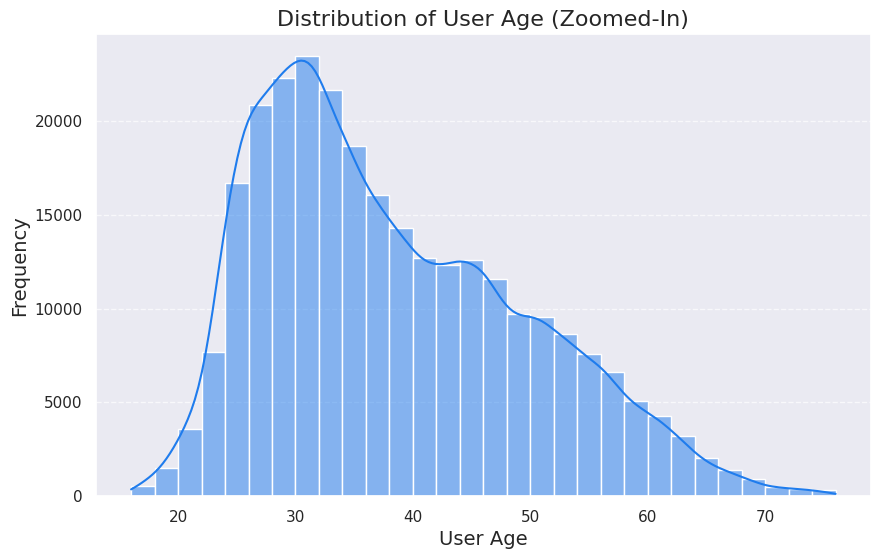

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(citibike_trip_sample_df[citibike_trip_sample_df['user_age'] <
                                     citibike_trip_sample_df['user_age'].quantile(0.999)],
             x='user_age', kde=True, color='#1f7ced', bins=30)
plt.title('Distribution of User Age (Zoomed-In)', fontsize=16)
plt.xlabel('User Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [16]:
citibike_trip_sample_df['user_age'].quantile(0.99), citibike_trip_sample_df['user_age'].quantile(0.999)

(67.0, 76.10700000001816)

In [17]:
print(citibike_trip_sample_df.query('user_age>=76').shape)
citibike_trip_sample_df.query('user_age>=76').head()

(339, 23)


tripduration           starttime            stoptime start_station_id  \
1636          1305 2014-10-18 08:25:00 2014-10-18 08:47:00              349   
3121           286 2016-07-28 18:41:00 2016-07-28 18:46:00              395   
3249          1411 2016-02-22 09:02:00 2016-02-22 09:25:00              446   
5975           976 2016-01-11 16:29:00 2016-01-11 16:45:00             3141   
7346          2327 2014-11-10 13:37:00 2014-11-10 14:16:00              408   

             start_station_name  start_station_latitude  \
1636    Rivington St & Ridge St               40.718502   
3121  Bond St & Schermerhorn St               40.688070   
3249            W 24 St & 7 Ave               40.744876   
5975            1 Ave & E 68 St               40.765005   
7346      Market St & Cherry St               40.710762   

      start_station_longitude end_station_id          end_station_name  \
1636               -73.983299            467           Dean St & 4 Ave   
3121               -73.984106           3246  Montague St & Clinton St   
3249               -73.995299            475       E 16 St & Irving Pl   
5975               -73.958185           3171   Amsterdam Ave & W 82 St   
7346               -73.994004            302         Avenue D & E 3 St   

      end_station_latitude  end_station_longitude  bikeid    usertype  \
1636             40.683125             -73.978951   17955  Subscriber   
3121             40.694281             -73.992300   25540  Subscriber   
3249             40.735243             -73.987586   22987  Subscriber   
5975             40.785247             -73.976673   20933  Subscriber   
7346             40.720828             -73.977932   19900  Subscriber   

      birth_year  gender  customer_plan  start_hour  start_month  start_year  \
1636      1910.0    male            NaN           8           10        2014   
3121      1940.0    male            NaN          18            7        2016   
3249      1940.0  female            NaN           9            2        2016   
5975      1939.0    male            NaN          16            1        2016   
7346      1936.0    male            NaN          13           11        2014   

      stop_hour  stop_month  stop_year  user_age  
1636          8          10       2014     104.0  
3121         18           7       2016      76.0  
3249          9           2       2016      76.0  
5975         16           1       2016      77.0  
7346         14          11       2014      78.0

* The user age range that is below 99.9th percentile is between 16 and 76 years old. From statistical perspectives, any person whose age is above 76 years is considered as outliers and potential anomalies. But based on our experience, people in their 80s or even 90s, might still have the ability to ride bikes. Although it is not highly recommended. However, we do see some records in the table show the ages that are above 100. These are most likely the anomalies.
* Based on the distribution of user age, most of the citibike users are between 20 and 60 years old. This is aligh with our experience that most users are daily commuters in the city.
* **Potential TODO Actions**: If we do see significant increase of senior people using the citibike, more measures need to be taken to ensure their safety while riding。 Additionally, the user manual should be made more user-friendly.


## **1.2.3 Gender and User Type Distribution**

In [18]:
print(citibike_trip_sample_df.gender.value_counts())
print('----------------')
print(citibike_trip_sample_df.usertype.value_counts())

gender
male       211692
female      64887
unknown     39206
Name: count, dtype: int64
----------------
usertype
Subscriber    277448
Customer       38337
Name: count, dtype: int64


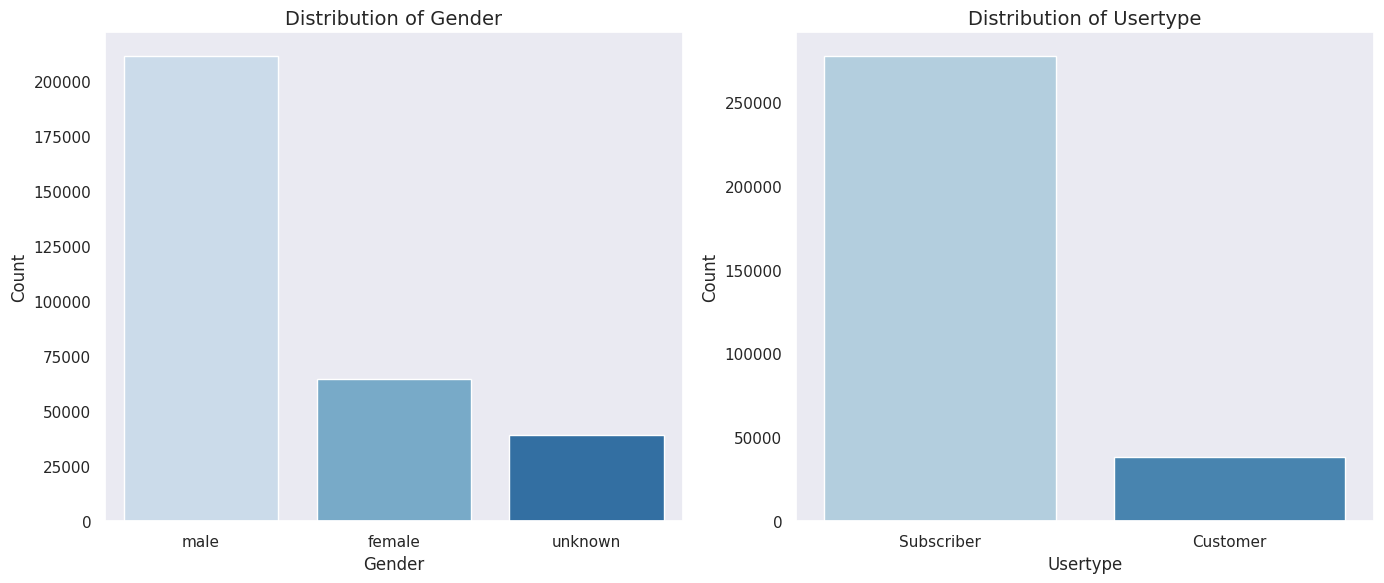

In [19]:
# Bar chart for categorical variables: gender and usertype
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Two charts side by side

# Bar chart for Gender
sns.countplot(data=citibike_trip_sample_df, x='gender', ax=axes[0], palette='Blues')
axes[0].set_title('Distribution of Gender', fontsize=14)
axes[0].set_xlabel('Gender', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Bar chart for Usertype
sns.countplot(data=citibike_trip_sample_df, x='usertype', ax=axes[1], palette='Blues')
axes[1].set_title('Distribution of Usertype', fontsize=14)
axes[1].set_xlabel('Usertype', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)


plt.tight_layout()



*   **Observation 1: The number of male users significantly exceeds that of female users**
  * The number of users from both genders should typically be similar. **This deviation from the norm is unusual.** If the data is accurate, it suggests there may be factors discouraging female users from utilizing Citibike.
  * There is one of the articles explained the potential reasons why females don't like riding Citi Bikes. ["Why Aren’t More Women Riding Citi Bikes?"](https://www.thecut.com/2015/07why-arent-more-women-riding-citi-bikes.html)
      -  Safety Concerns: Women often feel less safe navigating city traffic on bicycles, which can discourage them from using bike-sharing services.

      -  Convenience Issues: The design of Citi Bikes and the docking stations may not accommodate women's clothing choices, such as skirts or dresses, making the service less convenient for them.

      - Maintenance and Cleanliness: Women may be more sensitive to the cleanliness and maintenance of shared bikes, and any deficiencies in these areas can be a deterrent.

      - Marketing and Outreach: The marketing strategies of bike-sharing programs may not effectively target women, leading to lower awareness and usage among this demographic.

*   **Observation 2: Subscribers make up the majority of the overall user base**
  * Convenience and Accessibility: Annual members have 24/7 access to thousands of bikes across multiple boroughs, providing a reliable transportation alternative to subways, taxis, and buses.

  * This also leads to another **DISCUSSION**: Whether Citi Bike wants more customers who purchase 24-hour pass or 7-day pass. According to the pricing plan, the more customers will bring more profit. On the other hand, this might lower the bike availability for subscribers who have the annual membership.





## **1.2.4 Trip Duration**

In [20]:
# Check the quantile and percentile of the trip duration
q1 = citibike_trip_sample_df['tripduration'].quantile(0.01)
q99 = citibike_trip_sample_df['tripduration'].quantile(0.99)
percentile_24hr = percentileofscore(citibike_trip_sample_df['tripduration'], 24*60*60, kind='rank') / 100

# Printing the information
print(f"1st Percentile (0.01 Quantile) of 'tripduration': {q1}")
print(f"99th Percentile (0.99 Quantile) of 'tripduration': {q99}")
print(f"Percentile rank of 24 hours (in seconds) for 'tripduration': {percentile_24hr:.4f}")

1st Percentile (0.01 Quantile) of 'tripduration': 119.0
99th Percentile (0.99 Quantile) of 'tripduration': 3879.0
Percentile rank of 24 hours (in seconds) for 'tripduration': 0.9998


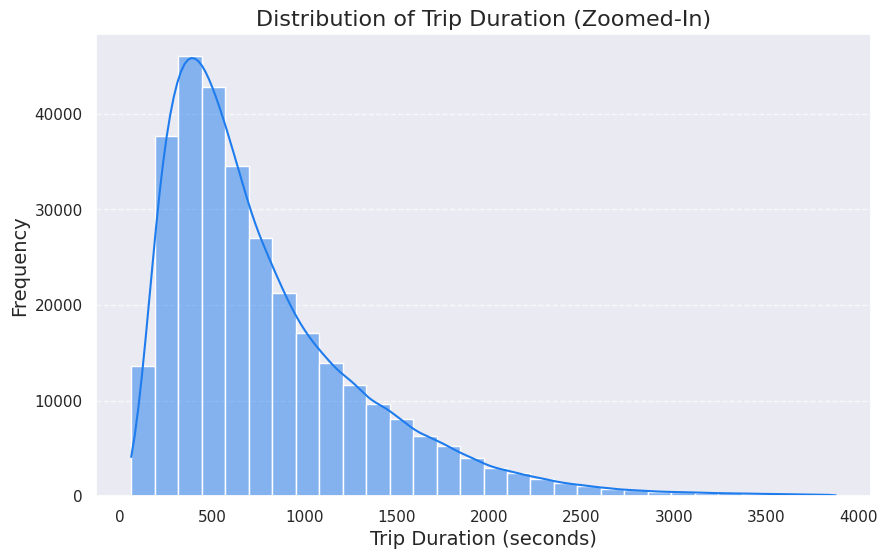

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(citibike_trip_sample_df[citibike_trip_sample_df['tripduration'] <
                                     citibike_trip_sample_df['tripduration'].quantile(0.99)],
             x='tripduration', kde=True, color='#1f7ced', bins=30)
plt.title('Distribution of Trip Duration (Zoomed-In)', fontsize=16)
plt.xlabel('Trip Duration (seconds)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# # Boxplot to Highlight Outliers
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=citibike_trip_sample_df, y='tripduration', color='skyblue')
# plt.title('Boxplot of Trip Duration', fontsize=16)
# plt.ylabel('Trip Duration (seconds)', fontsize=14)
# plt.ylim(0, citibike_trip_sample_df['tripduration'].quantile(0.99))  # Focus on 99th percentile
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

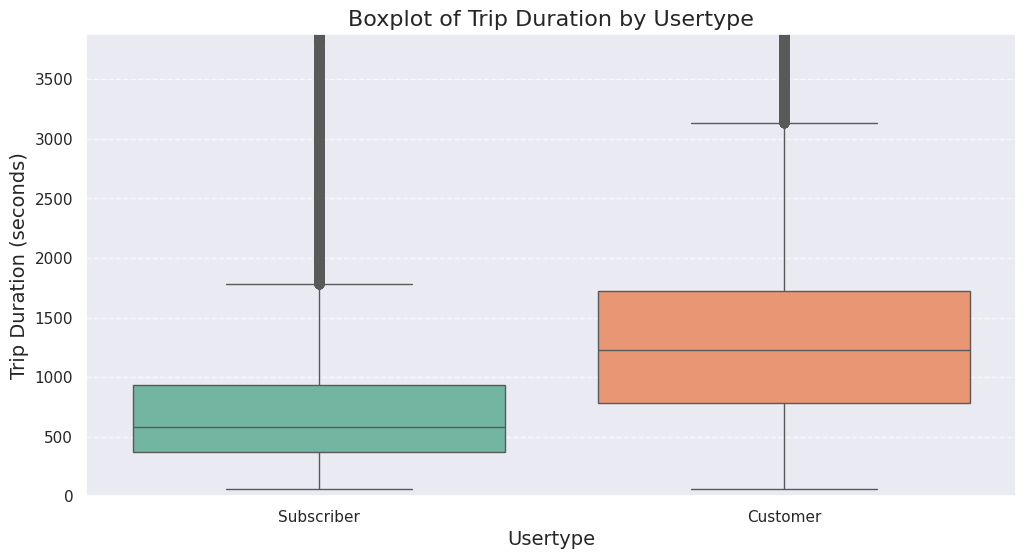

In [22]:
# Boxplot by Usertype
plt.figure(figsize=(12, 6))
sns.boxplot(data=citibike_trip_sample_df, x='usertype', y='tripduration', color='skyblue', palette='Set2')
plt.title('Boxplot of Trip Duration by Usertype', fontsize=16)
plt.xlabel('Usertype', fontsize=14)
plt.ylabel('Trip Duration (seconds)', fontsize=14)
plt.ylim(0, citibike_trip_sample_df['tripduration'].quantile(0.99))  # Focus on 99th percentile
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

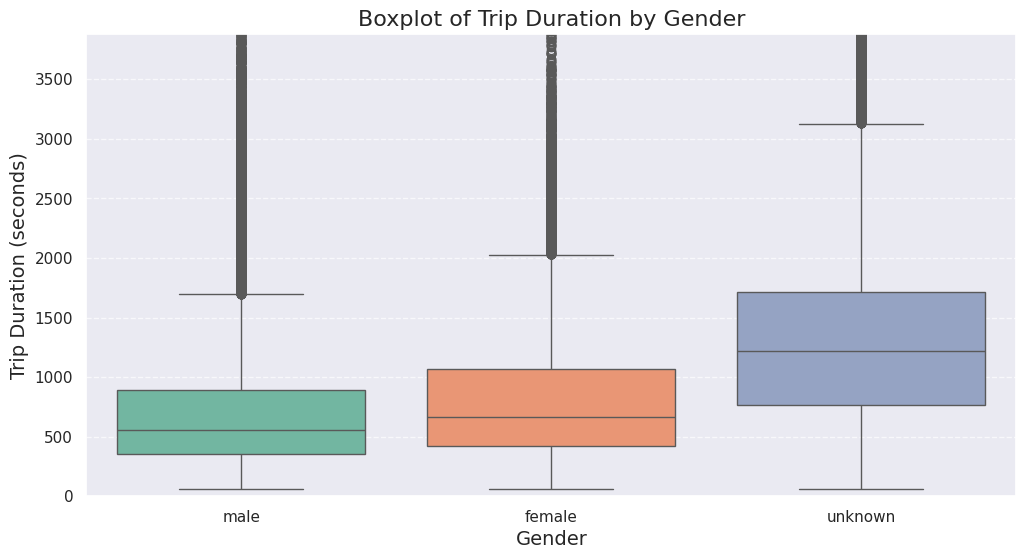

In [23]:
# Boxplot by Gender
plt.figure(figsize=(12, 6))
sns.boxplot(data=citibike_trip_sample_df, x='gender', y='tripduration', color='skyblue', palette='Set2')
plt.title('Boxplot of Trip Duration by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Trip Duration (seconds)', fontsize=14)
plt.ylim(0, citibike_trip_sample_df['tripduration'].quantile(0.99))  # Focus on 99th percentile
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# # Distribution plot for Tripduration
# plt.figure(figsize=(10, 6))
# sns.histplot(data=citibike_trip_sample_df, x='tripduration', kde=True, color='Purple', bins=300)
# plt.title('Distribution of Trip Duration', fontsize=16)
# plt.xlabel('Trip Duration (seconds)', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.show()

In [24]:
trip_start_hour_map_data = citibike_trip_sample_df.groupby(['start_station_name', 'start_station_latitude', 'start_station_longitude', 'start_hour']).size().reset_index(name='count')
trip_start_hour_map_data.columns = ['station_name', 'latitude', 'longitude', 'hour', 'count']
trip_end_hour_map_data = citibike_trip_sample_df.groupby(['end_station_name', 'end_station_latitude', 'end_station_longitude', 'stop_hour']).size().reset_index(name='count')
trip_end_hour_map_data.columns = ['station_name', 'latitude', 'longitude', 'hour', 'count']
trip_start_hour_map_data.shape, trip_end_hour_map_data.shape

((11536, 5), (11607, 5))

In [25]:
trip_start_month_map_data = citibike_trip_sample_df.groupby(['start_station_name', 'start_station_latitude', 'start_station_longitude', 'start_month']).size().reset_index(name='count')
trip_start_month_map_data.columns = ['station_name', 'latitude', 'longitude', 'month', 'count']
trip_end_month_map_data = citibike_trip_sample_df.groupby(['end_station_name', 'end_station_latitude', 'end_station_longitude', 'stop_month']).size().reset_index(name='count')
trip_end_month_map_data.columns = ['station_name', 'latitude', 'longitude', 'month', 'count']
trip_start_month_map_data.shape, trip_end_month_map_data.shape

((6052, 5), (6062, 5))

In [26]:
trip_start_hour_map_data.latitude.mean(), trip_start_hour_map_data.longitude.mean()

(40.73075455494539, -73.98023185396151)

In [ ]:
# trip_end_hour_map_data.head(10)

## **1.2.5 Geolocation Distribution of Citibike Station in Use Over Time**

In [128]:
# def draw_heatmap(df):
#   # Create a base map
#   m = folium.Map(location=[40.73, -73.98], zoom_start=12, width=800, height=800)
#   # Add heatmap to the map
#   heat_data = [[row['latitude'], row['longitude'], row['count']] for index, row in df.iterrows()]
#   HeatMap(heat_data, radius=15).add_to(m)
#   return m

In [129]:
# def draw_heatmap_with_time(df, timeframe_col = 'hour'):
#     # Ensure 'hour' is sorted for proper time sequencing
#     df = df.sort_values(by=timeframe_col)

#     # Group data by hour and prepare heatmap data
#     heat_data = []
#     for hour, group in df.groupby(timeframe_col):
#         heat_data.append(
#             [[row['latitude'], row['longitude'], row['count']] for _, row in group.iterrows()]
#         )

#     # Create a base map
#     m = folium.Map(location=[40.73, -73.98], zoom_start=12, width=800, height=800)

#     # Add the HeatMapWithTime layer
#     HeatMapWithTime(
#         data=heat_data,
#         radius=20,
#         index=list(df[timeframe_col].unique()),  # Use unique 'hour' values as the time index
#         auto_play=True,  # Automatically play through frames
#         max_opacity=0.5,  # Reduce the opacity for a softer visual effect
#         scale_radius=False,# Keep the radius consistent
#         # scale_radius=True,
#         #  gradient={0.1: 'blue', 0.3: 'cyan', 0.5: 'green', 0.75: 'yellow', 1: 'red'}

#     ).add_to(m)

#     return m


In [127]:
# display(draw_heatmap_with_time(trip_start_hour_map_data, 'hour'))

In [124]:
def draw_heatmap_with_time_plotly(df, timeframe_col='hour'):
    """
    Create an animated heatmap using Plotly to display usage over time with a constant scale.

    Parameters:
    - df: DataFrame with columns ['station_name', 'latitude', 'longitude', 'hour', 'count'].
    - timeframe_col: The column representing time (e.g., 'hour').

    Returns:
    - fig: A Plotly figure object.
    """
    # Sort by time for proper sequencing
    df = df.sort_values(by=timeframe_col)

    # Determine consistent size and color scales
    max_count = df['count'].max()

    # Create an animated scatter map
    fig = px.scatter_mapbox(
        df,
        lat='latitude',
        lon='longitude',
        size='count',
        color='count',
        animation_frame=timeframe_col,
        hover_name='station_name',
        size_max=15,  # Maximum size of the circle
        zoom=11,
        mapbox_style="carto-positron",
        title="Bike Usage Over Time (Constant Scale)"
    )

    # Set consistent size and color scales
    fig.update_traces(marker=dict(sizemin=3))  # Set a minimum circle size
    fig.update_layout(
        coloraxis_colorbar=dict(title="Usage Count"),
        coloraxis=dict(cmin=0, cmax=max_count),  # Constant color scale
        margin={"r": 0, "t": 50, "l": 0, "b": 0},
        width=900,  # Narrower width
        height=900  # Taller height
    )

    return fig

In [130]:

fig = draw_heatmap_with_time_plotly(trip_start_hour_map_data, 'hour')
fig.show()

In [131]:
fig = draw_heatmap_with_time_plotly(trip_end_hour_map_data, 'hour')
fig.show()

In [132]:
fig = draw_heatmap_with_time_plotly(trip_start_month_map_data, 'month')
fig.show()

In [133]:
fig = draw_heatmap_with_time_plotly(trip_end_month_map_data, 'month')
fig.show()

## **1.2.6 Number of Trips By Month and By Day of Week**

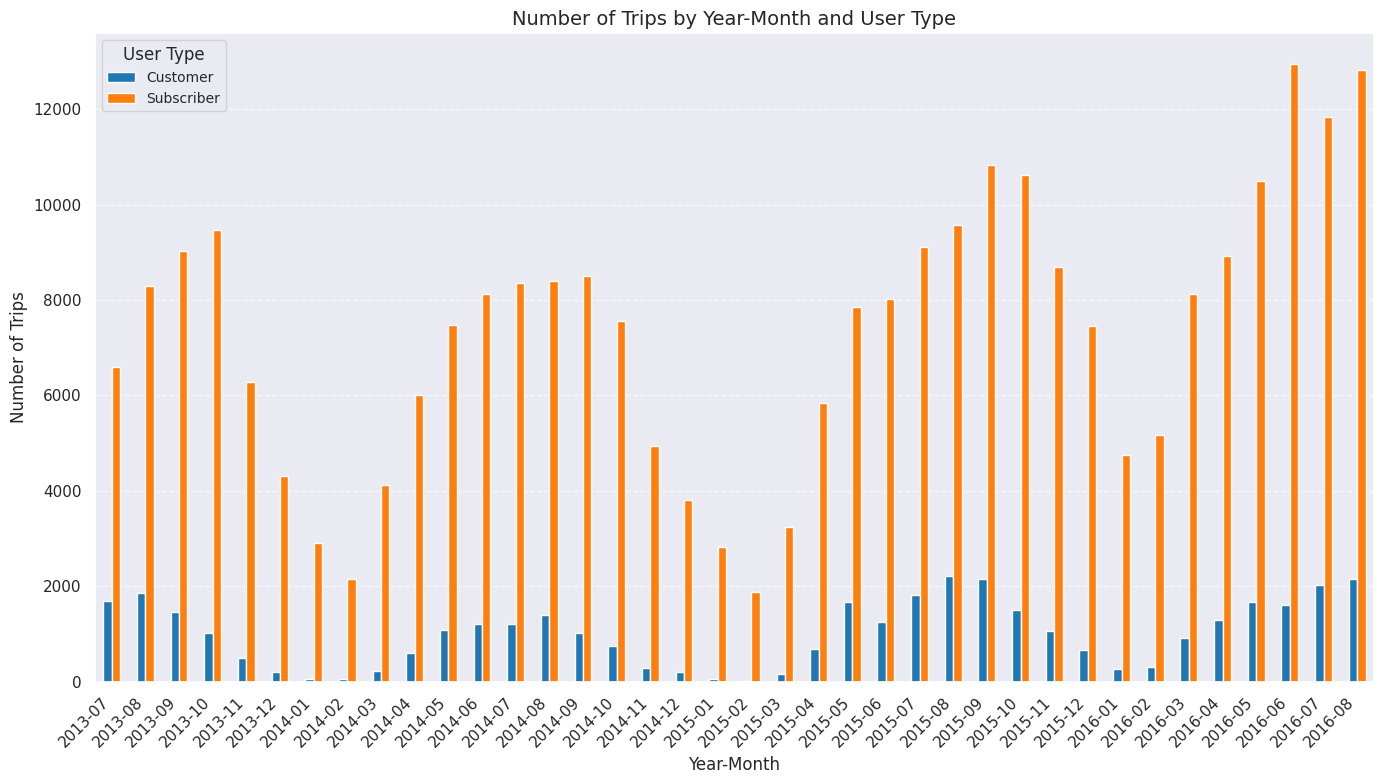

In [29]:
# Create a 'year_month' column
citibike_trip_sample_df['year_month'] = (
    citibike_trip_sample_df['start_year'].astype(str) + "-" +
    citibike_trip_sample_df['start_month'].astype(str).str.zfill(2)
)

# Group data by year_month and usertype
grouped_data = citibike_trip_sample_df.groupby(['year_month', 'usertype']).size().reset_index(name='num_trips')

# Pivot the data for plotting
pivot_data = grouped_data.pivot(index='year_month', columns='usertype', values='num_trips').fillna(0)

# Plot the data as separate bar plots for each user type
fig, ax = plt.subplots(figsize=(14, 8))
pivot_data.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'])

# Set plot details
ax.set_title('Number of Trips by Year-Month and User Type', fontsize=14)
ax.set_xlabel('Year-Month', fontsize=12)
ax.set_ylabel('Number of Trips', fontsize=12)
ax.legend(title='User Type', fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

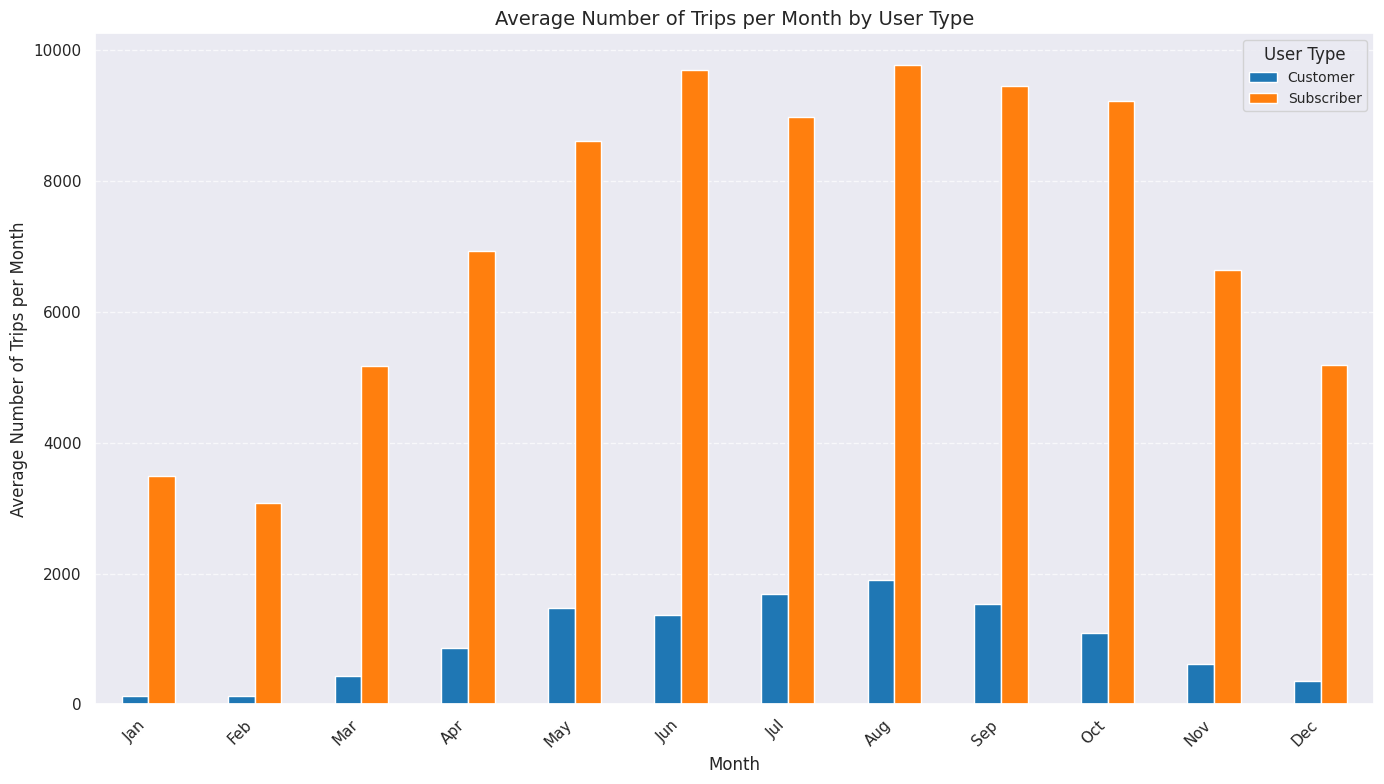

In [30]:
import calendar
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Map month numbers to abbreviated names
citibike_trip_sample_df['month_name'] = citibike_trip_sample_df['start_month'].map(
    lambda x: calendar.month_abbr[x]
)
monthly_trips = (
    citibike_trip_sample_df.groupby(['month_name', 'year_month', 'usertype'])
    .size()
    .reset_index(name='monthly_trips')
)

# Calculate the average number of trips per month for each year_month and usertype
avg_monthly_trips = (
    monthly_trips.groupby(['month_name', 'usertype'])['monthly_trips']
    .mean()
    .reset_index(name='avg_trips_per_month')
)

avg_monthly_trips['month_name'] = pd.Categorical(
    avg_monthly_trips['month_name'], categories=month_order, ordered=True
)
# Pivot the data for plotting
pivot_avg_monthly_trips = avg_monthly_trips.pivot(index='month_name', columns='usertype', values='avg_trips_per_month').fillna(0)

# Plot the average trips as a bar plot
fig, ax = plt.subplots(figsize=(14, 8))
pivot_avg_monthly_trips.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'])

# Customize the plot
ax.set_title('Average Number of Trips per Month by User Type', fontsize=14)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average Number of Trips per Month', fontsize=12)
ax.legend(title='User Type', fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

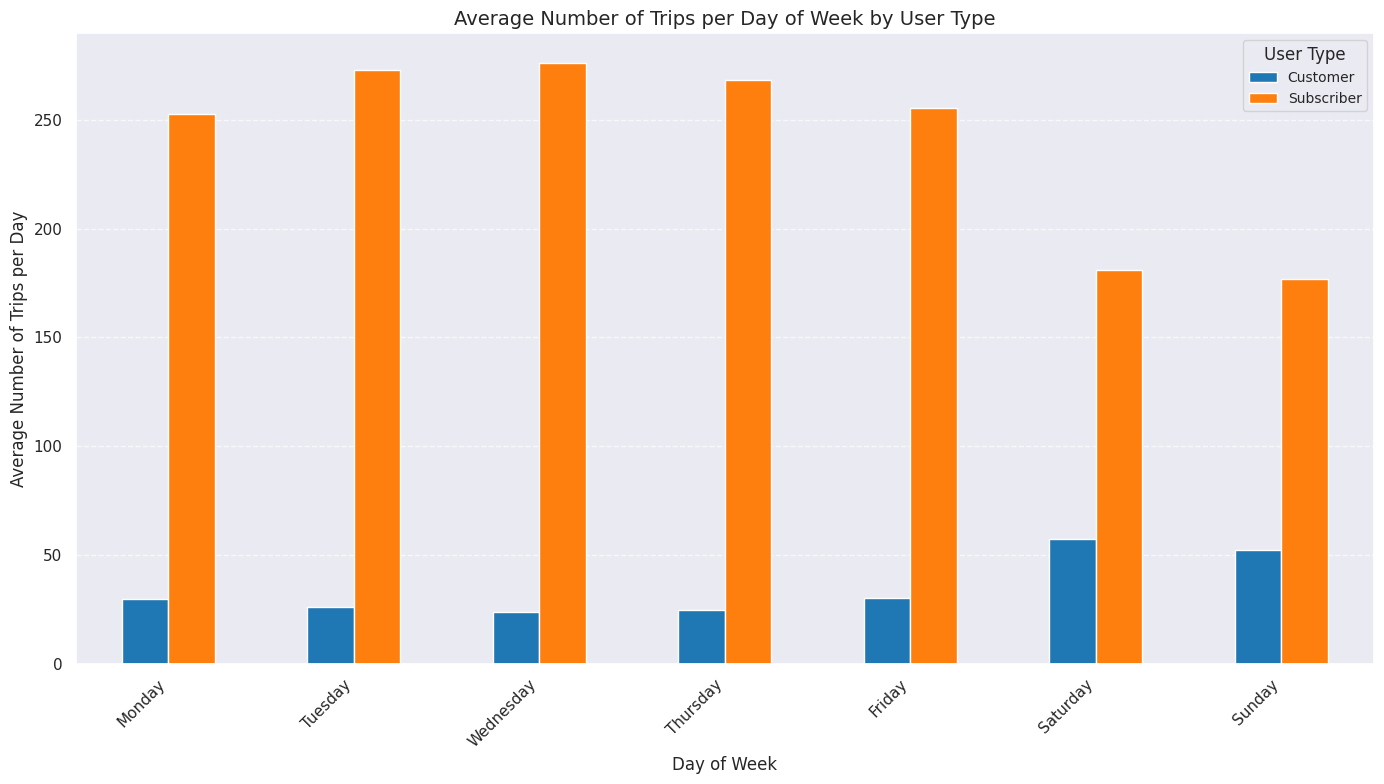

In [59]:
# Extract the day of the week
citibike_trip_sample_df['day_of_week'] = citibike_trip_sample_df['starttime'].dt.day_name()

# Extract the date part from 'starttime'
citibike_trip_sample_df['start_date'] = citibike_trip_sample_df['starttime'].dt.date
citibike_trip_sample_df['stop_date'] = citibike_trip_sample_df['stoptime'].dt.date

# Group by day_of_week, usertype, and start_date to calculate the number of trips per day
daily_trips = (
    citibike_trip_sample_df.groupby(['day_of_week', 'usertype', 'start_date'])
    .size()
    .reset_index(name='daily_trips')
)

# Calculate the average number of trips per day for each day_of_week and usertype
avg_trips = (
    daily_trips.groupby(['day_of_week', 'usertype'])['daily_trips']
    .mean()
    .reset_index(name='avg_trips_per_day')
)

# Ensure the days are in the correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_trips['day_of_week'] = pd.Categorical(avg_trips['day_of_week'], categories=day_order, ordered=True)

# Pivot the data for plotting
pivot_avg_trips = avg_trips.pivot(index='day_of_week', columns='usertype', values='avg_trips_per_day').fillna(0)

# Plot the average trips as a bar plot
fig, ax = plt.subplots(figsize=(14, 8))
pivot_avg_trips.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'])

# Customize the plot
ax.set_title('Average Number of Trips per Day of Week by User Type', fontsize=14)
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Average Number of Trips per Day', fontsize=12)
ax.legend(title='User Type', fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Customers tend to use citibike during weekends whereas subscribers usuallly use them during the week days.

This is aligned with our impression as Citi Bike customers (1-day or 7-day pass holders) are typically tourists who often visit NYC on weekends. On the other hand, Citi Bike subscribers (annual pass holders) are usually daily commuters and tend to use the bikes more frequently on weekdays.

## **2. Citibike Usage Forecast**

## **2.1 Remove Outliers**

In [60]:
# Remove outliers
citibike_trip_sample_clean_df = citibike_trip_sample_df.copy()
print(citibike_trip_sample_df.shape)
citibike_trip_sample_clean_df = citibike_trip_sample_clean_df.query('starttime<stoptime')
print(citibike_trip_sample_clean_df.shape)
citibike_trip_sample_clean_df = citibike_trip_sample_clean_df.query('tripduration < 24*60*60')
print(citibike_trip_sample_clean_df.shape)
## Most customers don't put birth year when rent a bike. And this is not the most essential info when it comes to usage forecast
# citibike_trip_sample_clean_df = citibike_trip_sample_clean_df.query('user_age < 76')
# print(citibike_trip_sample_clean_df.shape)

(315785, 28)
(315784, 28)
(315712, 28)


In [61]:
citibike_trip_sample_df.head()

tripduration           starttime            stoptime start_station_id  \
0          2319 2016-03-09 13:08:00 2016-03-09 13:47:00              520   
1           313 2015-07-09 15:42:00 2015-07-09 15:47:00              520   
2           906 2016-01-11 18:32:00 2016-01-11 18:47:00              520   
3           716 2013-10-30 11:53:00 2013-10-30 12:05:00              520   
4           312 2014-06-04 16:12:00 2014-06-04 16:17:00              520   

  start_station_name  start_station_latitude  start_station_longitude  \
0    W 52 St & 5 Ave               40.759923               -73.976485   
1    W 52 St & 5 Ave               40.759923               -73.976485   
2    W 52 St & 5 Ave               40.759923               -73.976485   
3    W 52 St & 5 Ave               40.759923               -73.976485   
4    W 52 St & 5 Ave               40.759923               -73.976485   

  end_station_id          end_station_name  end_station_latitude  \
0            363            West Thames St             40.708347   
1            493           W 45 St & 6 Ave             40.756800   
2           3162        W 78 St & Broadway             40.783400   
3            533        Broadway & W 39 St             40.752996   
4            519  E 42 St & Vanderbilt Ave             40.752416   

   end_station_longitude  bikeid    usertype  birth_year  gender  \
0             -74.017134   23062  Subscriber      1972.0    male   
1             -73.982912   16909  Subscriber      1968.0  female   
2             -73.980931   15614  Subscriber      1961.0    male   
3             -73.987216   19280  Subscriber      1954.0    male   
4             -73.978370   16483  Subscriber      1963.0    male   

   customer_plan  start_hour  start_month  start_year  stop_hour  stop_month  \
0            NaN          13            3        2016         13           3   
1            NaN          15            7        2015         15           7   
2            NaN          18            1        2016         18           1   
3            NaN          11           10        2013         12          10   
4            NaN          16            6        2014         16           6   

   stop_year  user_age year_month month_name day_of_week  start_date  \
0       2016      44.0    2016-03        Mar   Wednesday  2016-03-09   
1       2015      47.0    2015-07        Jul    Thursday  2015-07-09   
2       2016      55.0    2016-01        Jan      Monday  2016-01-11   
3       2013      59.0    2013-10        Oct   Wednesday  2013-10-30   
4       2014      51.0    2014-06        Jun   Wednesday  2014-06-04   

    stop_date  
0  2016-03-09  
1  2015-07-09  
2  2016-01-11  
3  2013-10-30  
4  2014-06-04

## **2.2 Citibike Daily Usage Forecast with All Usertypes**
TODO:
1. Interpret the MAE and MSE
2. Explain the trend and seasonality
3. Other factors that may increase the accuracy: wheahter, safety, promotion
4. Prediction based on user type?

In [34]:
def usage_forecast(df):
  daily_trips = df.groupby(df['starttime'].dt.to_period('D')).size()
  daily_trips.index = daily_trips.index.to_timestamp()  # Convert to DatetimeIndex


  daily_trips = daily_trips.reset_index()
  # Ensure time series has a continuous index (fill missing days with 0 trips)
  # daily_trips = daily_trips.asfreq('D', fill_value=0)
  daily_trips.columns = ['ds', 'y']  # Rename columns for Prophet compatibility

  # Split data for training and testing
  train = daily_trips[(daily_trips['ds'] >= '2013-07-01') & (daily_trips['ds'] <= '2016-06-30')]
  test = daily_trips[(daily_trips['ds'] >= '2016-07-01') & (daily_trips['ds'] <= '2016-08-30')]

  # Initialize and train the Prophet model
  model = Prophet(interval_width=0.95) # Set to 95% confidence interval (default value is 80%)
  model.add_seasonality(name='weekly', period=7, fourier_order=3)
  model.add_seasonality(name='yearly', period=365.25, fourier_order=5)
  model.fit(train)

  # Make predictions for the test period
  future = model.make_future_dataframe(periods=365, freq='D')
  forecast = model.predict(future)

  # Extract predictions for the test period
  forecast_test = forecast[forecast['ds'].isin(test['ds'])]

  # Calculate evaluation metrics
  y_true = test['y'].values
  y_pred = forecast_test['yhat'].values

  # Mean Absolute Error (MAE)
  mae = mean_absolute_error(y_true, y_pred)

  # Mean Absolute Percentage Error (MAPE)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

  # Root Mean Squared Error (RMSE)
  rmse = mean_squared_error(y_true, y_pred, squared=False)

  # Root Mean Squared Percentage Error (RMSPE)
  rmspe = np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100

  # Print metrics
  print(f"Mean Absolute Error (MAE): {mae:.2f}")
  print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
  print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
  print(f"Root Mean Squared Percentage Error (RMSPE): {rmspe:.2f}%")

 # Create side-by-side plots
  fig, axes = plt.subplots(1, 2, figsize=(18, 6))

  # Full Forecast Plot
  axes[0].set_title('Prophet Forecast: Daily Trips')
  fig_full = model.plot(forecast, ax=axes[0])
  axes[0].scatter(test['ds'], test['y'], color='orange', label='Test Data', zorder=3, s=10)  # Add test data points
  axes[0].set_xlabel('Date')
  axes[0].set_ylabel('Number of Trips')
  axes[0].legend()

  # Zoomed-In Forecast Plot
  axes[1].set_title('Prophet Forecast: Zoomed-In for Last Two Months')
  fig_zoom = model.plot(forecast, ax=axes[1])
  axes[1].plot(
      test['ds'], test['y'],
      color='orange',
      label='Test Data (Line)',
      zorder=2,
      linestyle='-',
      marker='o',
      linewidth=1  # Adjust line thickness
  )
  axes[1].set_xlim(pd.Timestamp('2016-07-01'), pd.Timestamp('2016-08-30'))
  axes[1].set_xlabel('Date')
  axes[1].set_ylabel('Number of Trips')
  axes[1].legend()

  # Adjust layout
  plt.tight_layout()
  plt.show()

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp75obp1po/2d8il7kg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp75obp1po/qhas8nn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93401', 'data', 'file=/tmp/tmp75obp1po/2d8il7kg.json', 'init=/tmp/tmp75obp1po/qhas8nn6.json', 'output', 'file=/tmp/tmp75obp1po/prophet_modelr7zlq8xe/prophet_model-20241204010439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:04:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:04:39 - cmdstanpy - INFO - Chain [1] done proc

Mean Absolute Error (MAE): 50.96
Mean Absolute Percentage Error (MAPE): 12.67%
Root Mean Squared Error (RMSE): 67.11
Root Mean Squared Percentage Error (RMSPE): 19.09%


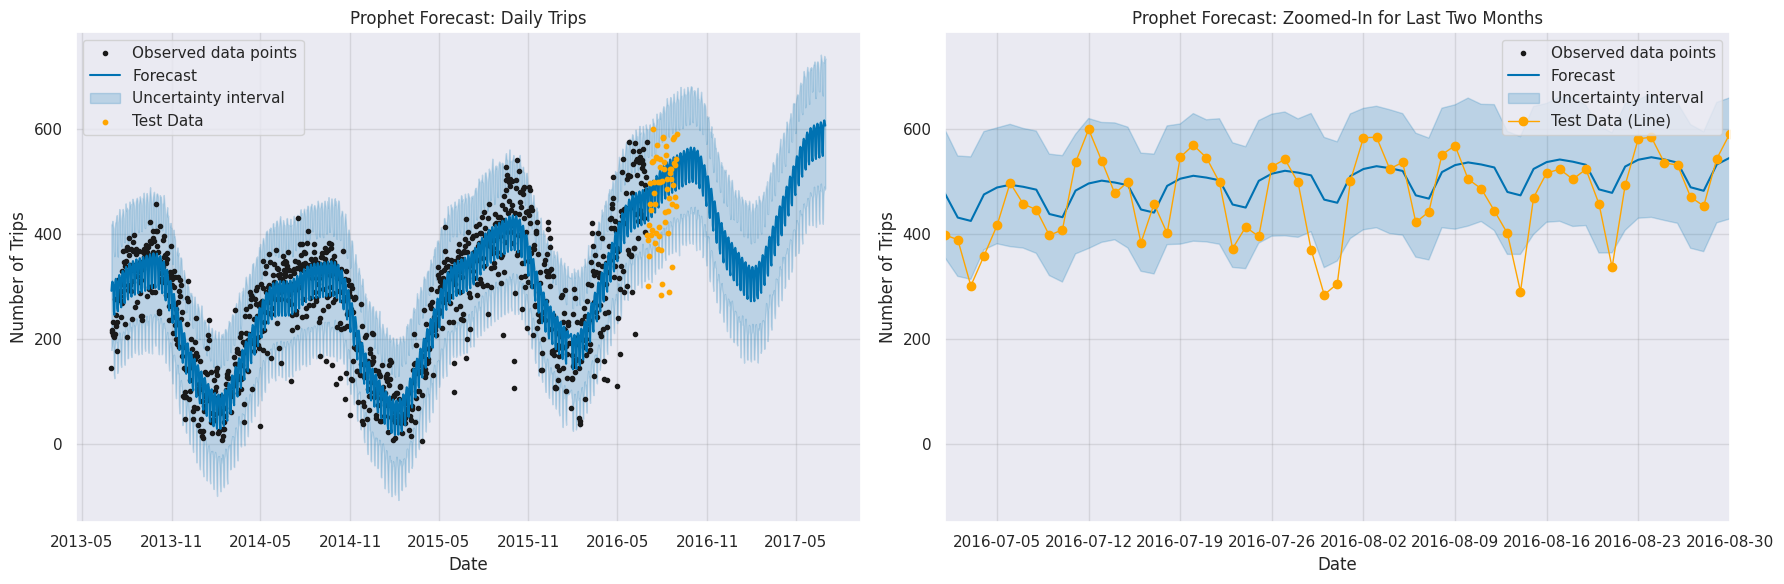

In [35]:
usage_forecast(citibike_trip_sample_clean_df)

In [36]:
# Aggregate daily data
subscriber_citibike_trip_sample_clean_df = citibike_trip_sample_clean_df.query('usertype=="Subscriber"')
customer_citibike_trip_sample_clean_df = citibike_trip_sample_clean_df.query('usertype=="Customer"')

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp75obp1po/hd5n1hr8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp75obp1po/le_g6asp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79158', 'data', 'file=/tmp/tmp75obp1po/hd5n1hr8.json', 'init=/tmp/tmp75obp1po/le_g6asp.json', 'output', 'file=/tmp/tmp75obp1po/prophet_model3hysq6dz/prophet_model-20241204010444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:04:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:04:44 - cmdstanpy - INFO - Chain [1] done proc

Mean Absolute Error (MAE): 53.27
Mean Absolute Percentage Error (MAPE): 17.06%
Root Mean Squared Error (RMSE): 69.65
Root Mean Squared Percentage Error (RMSPE): 26.53%


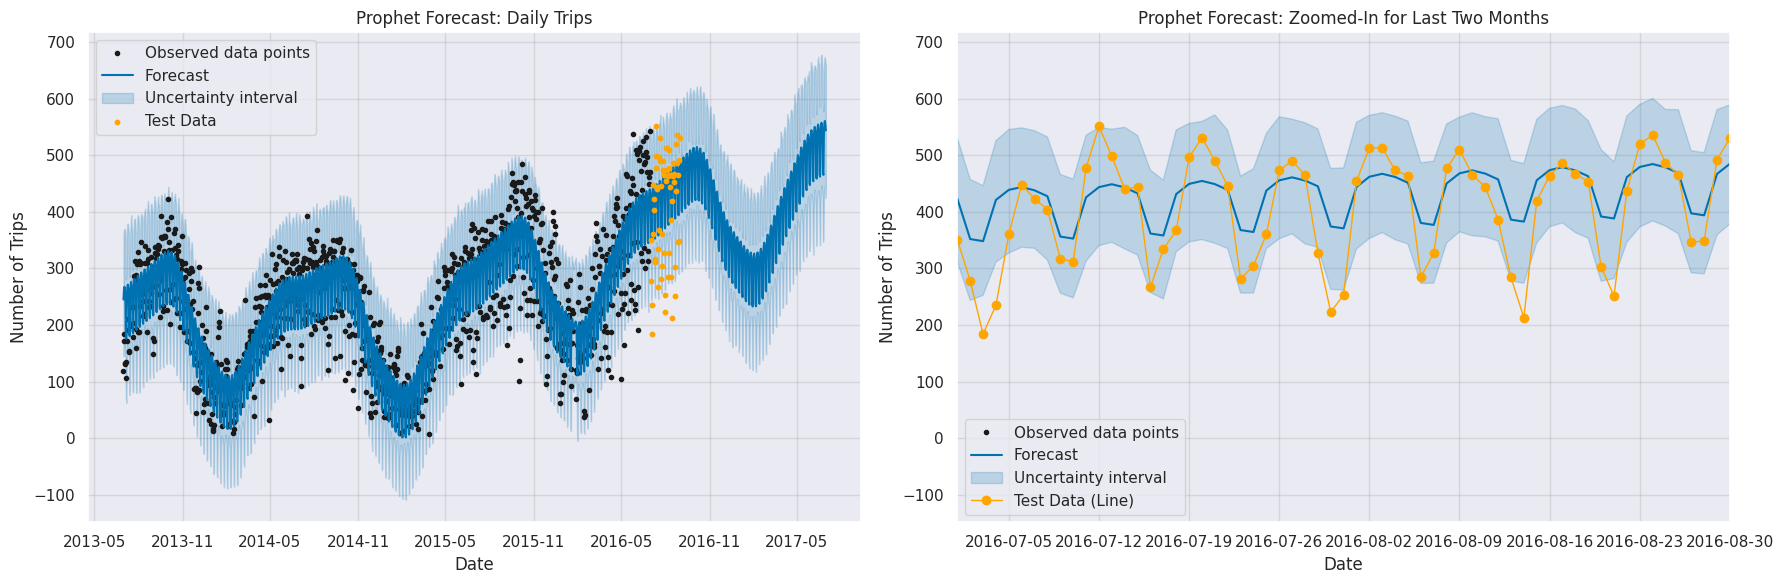

In [37]:
usage_forecast(subscriber_citibike_trip_sample_clean_df)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp75obp1po/p8r8n6up.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp75obp1po/q0di1urz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65019', 'data', 'file=/tmp/tmp75obp1po/p8r8n6up.json', 'init=/tmp/tmp75obp1po/q0di1urz.json', 'output', 'file=/tmp/tmp75obp1po/prophet_model3xgxfbzb/prophet_model-20241204010453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:04:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:04:53 - cmdstanpy - INFO - Chain [1] done proc

Mean Absolute Error (MAE): 17.33
Mean Absolute Percentage Error (MAPE): 28.24%
Root Mean Squared Error (RMSE): 22.23
Root Mean Squared Percentage Error (RMSPE): 36.40%


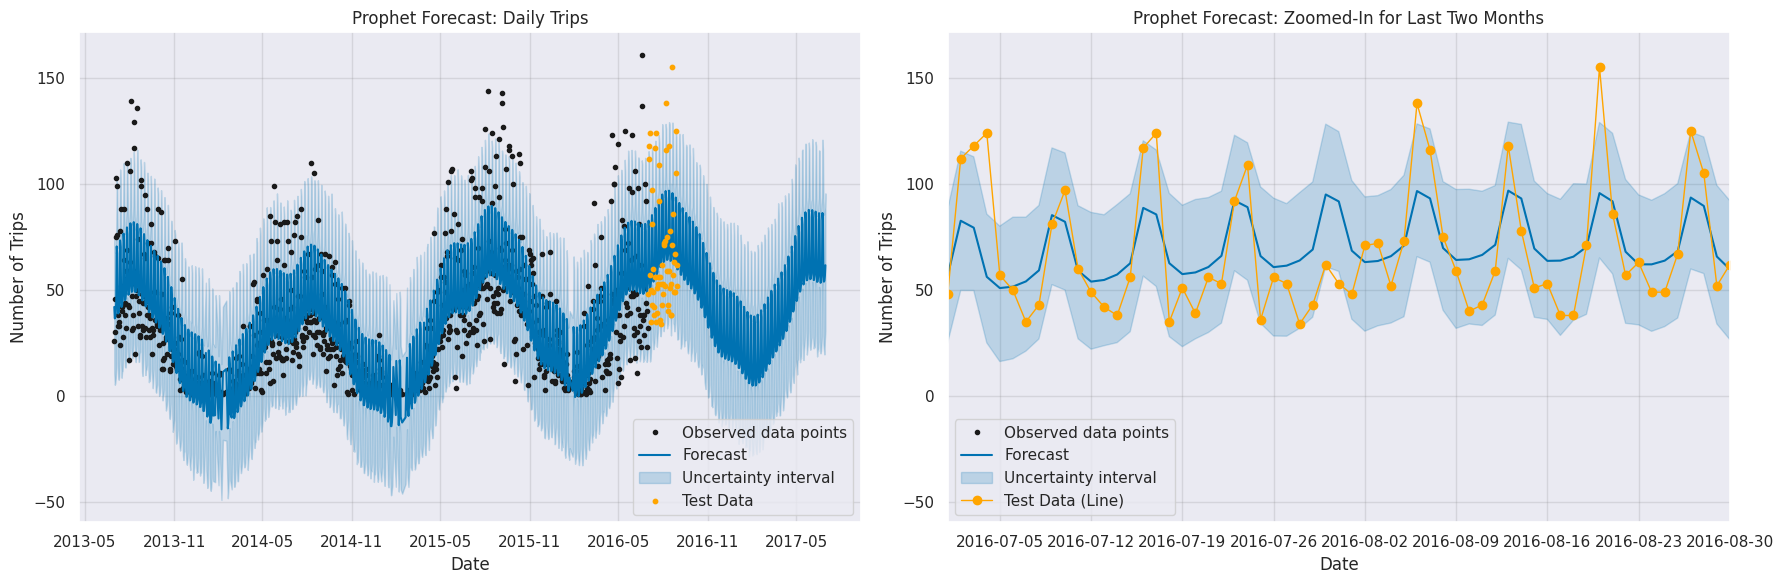

In [38]:
usage_forecast(customer_citibike_trip_sample_clean_df)

## **3. Bike Station Insights**

In [115]:
df = citibike_trip_sample_clean_df.copy()

# Calculate the usage for each station
start_usage = df.groupby(['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']).size().reset_index(name='start_count')
end_usage = df.groupby(['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']).size().reset_index(name='end_count')

# Merge start and end usage to calculate total usage for each station
station_usage = pd.merge(start_usage, end_usage,
                         left_on='start_station_id', right_on='end_station_id',
                         how='outer')

# Fill NaN values with 0 and calculate total usage
station_usage.fillna({'start_count': 0, 'end_count': 0}, inplace=True)
station_usage['total_usage'] = station_usage['start_count'] + station_usage['end_count']

# Merge latitude and longitude information
station_usage['latitude'] = station_usage['start_station_latitude'].where(
    ~station_usage['start_station_latitude'].isnull(), station_usage['end_station_latitude'])
station_usage['longitude'] = station_usage['start_station_longitude'].where(
    ~station_usage['start_station_longitude'].isnull(), station_usage['end_station_longitude'])

# Use `start_station_name` if available; otherwise, fall back to `end_station_name`
station_usage['station_name'] = station_usage['start_station_name'].where(
    station_usage['start_station_name'] != '', station_usage['end_station_name'])



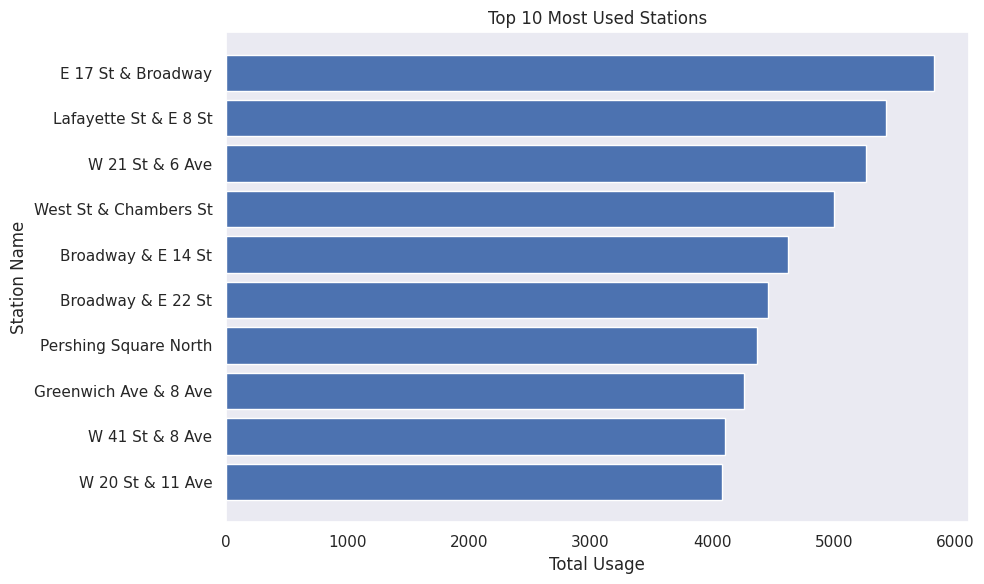

In [116]:
# Sort by total usage and get the top 10 most used stations
top_stations = station_usage[['station_name', 'total_usage']].sort_values(by='total_usage', ascending=True).tail(10)

# Draw the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_stations['station_name'], top_stations['total_usage'])
plt.title('Top 10 Most Used Stations')
plt.xlabel('Total Usage')
plt.ylabel('Station Name')
plt.tight_layout()
plt.show()


In [134]:
import plotly.express as px

# Get the top 100 most used stations
top_100_stations = station_usage[['station_name', 'latitude', 'longitude', 'total_usage']].sort_values(by='total_usage', ascending=False).head(100)

# Plot the top 100 stations on the map using Plotly
fig = px.scatter_mapbox(
    top_100_stations,
    lat="latitude",
    lon="longitude",
    size="total_usage",
    color="total_usage",
    hover_name="station_name",
    size_max=15,
    zoom=12,
    mapbox_style="carto-positron",
    title="Top 100 Most Used Citibike Stations"
)
fig.update_layout(
        width=900,  # Narrower width
        height=900  # Taller height
    )
fig.show()


In [149]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Add bike_in and bike_out columns
df['bike_out'] = -1  # Bikes leaving the station
df['bike_in'] = 1    # Bikes arriving at the station

# Calculate bike outflows (grouped by start hour)
outflow = df.groupby(['start_station_id', 'start_hour'])['bike_out'].sum().reset_index()

# Calculate bike inflows (grouped by stop hour)
inflow = df.groupby(['end_station_id', 'stop_hour'])['bike_in'].sum().reset_index()

# Rename columns for consistency
outflow.rename(columns={'start_station_id': 'station_id', 'start_hour': 'hour'}, inplace=True)
inflow.rename(columns={'end_station_id': 'station_id', 'stop_hour': 'hour'}, inplace=True)

# Combine inflow and outflow into a single DataFrame
bike_flow = pd.concat([outflow, inflow], axis=0, ignore_index=True)

# Group by station and hour to calculate net bike flow (inflow - outflow)
bike_flow = bike_flow.groupby(['station_id', 'hour']).sum().reset_index()
bike_flow['net_flow'] = bike_flow['bike_in'] + bike_flow['bike_out']

# Prepare data for clustering: pivot to have stations as rows and net flow as columns
time_series_matrix = bike_flow.pivot_table(
    index='station_id',
    columns='hour',
    values='net_flow',
    fill_value=0
)

# Standardize the data for clustering
scaler = StandardScaler()
time_series_scaled = scaler.fit_transform(time_series_matrix)


In [150]:
bike_flow.head()

station_id  hour  bike_out  bike_in  net_flow
0        116     0     -15.0     16.0       1.0
1        116     1     -10.0     14.0       4.0
2        116     2      -9.0     12.0       3.0
3        116     3      -3.0      3.0       0.0
4        116     4      -7.0      3.0      -4.0

In [151]:
time_series_matrix

hour          0    1    2    3    4     5     6     7     8     9     10  \
station_id                                                                 
116          1.0  4.0  3.0  0.0 -4.0  -7.0   6.0   7.0   2.0  39.0  10.0   
119          2.0 -1.0  1.0  0.0  0.0   0.0  -6.0  -3.0   0.0  -5.0  -5.0   
120          2.0  2.0  0.0  1.0 -1.0  -2.0  -4.0 -11.0 -26.0 -19.0  -3.0   
127         -8.0  0.0  1.0  2.0  2.0  -7.0 -10.0 -33.0 -31.0  65.0   4.0   
128          5.0  0.0 -6.0  1.0  3.0  -9.0   0.0  14.0  58.0  33.0   4.0   
...          ...  ...  ...  ...  ...   ...   ...   ...   ...   ...   ...   
546         18.0  3.0  2.0 -2.0  1.0  20.0 -11.0   7.0  40.0  49.0   9.0   
72           3.0 -2.0  3.0  0.0  2.0   8.0   1.0   0.0 -72.0  -5.0  -7.0   
79          -3.0  1.0 -2.0 -2.0  3.0   1.0  -1.0  -1.0  34.0  57.0  35.0   
82           8.0  2.0  1.0  1.0  3.0   1.0  -5.0  -5.0 -18.0  -5.0 -10.0   
83          -5.0  1.0  0.0  1.0  0.0   0.0  -8.0  -4.0   6.0  -6.0  -1.0   

hour          11    12    13    14    15    16    17    18    19    20    21  \
station_id                                                                     
116          1.0   9.0  12.0 -22.0  -9.0 -32.0 -30.0  -7.0  -8.0   3.0  20.0   
119         -3.0  -3.0   0.0   1.0   1.0   1.0   3.0   9.0  -5.0   3.0   5.0   
120         -3.0  -3.0  -5.0   5.0   0.0  -2.0  -3.0   7.0  10.0  13.0   3.0   
127        -28.0  -8.0 -13.0  11.0  -4.0  -1.0  27.0  13.0  16.0  -6.0   3.0   
128         -3.0   8.0  13.0 -27.0   9.0  -7.0 -22.0 -37.0 -31.0  22.0  10.0   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
546        -13.0  -9.0   6.0  -7.0 -19.0 -41.0 -56.0 -36.0   1.0  13.0   6.0   
72          -9.0  34.0  -6.0 -11.0  -7.0   2.0   6.0  17.0  -4.0  16.0  26.0   
79          11.0  -8.0  18.0  -6.0   7.0  -9.0 -20.0 -29.0  -4.0  -7.0   4.0   
82           0.0   4.0  -1.0  12.0  -2.0 -12.0   3.0  18.0   5.0  11.0   7.0   
83          -2.0   0.0   4.0   8.0  -7.0  14.0   3.0  13.0   8.0   2.0  -2.0   

hour          22    23  
station_id              
116         17.0  -1.0  
119          1.0   3.0  
120          7.0   6.0  
127          9.0  -4.0  
128          9.0   5.0  
...          ...   ...  
546          2.0  -3.0  
72           6.0   7.0  
79          -8.0  -7.0  
82          -2.0  11.0  
83         -13.0  -3.0  

[592 rows x 24 columns]

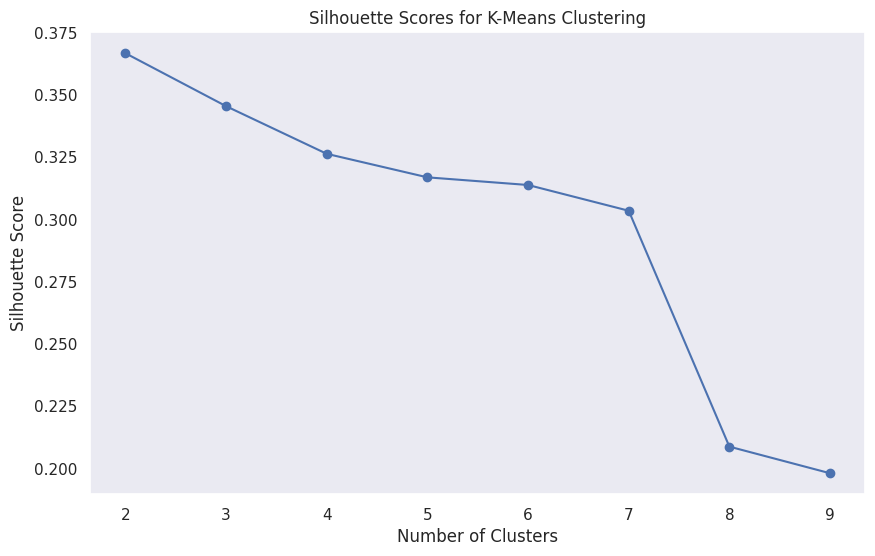

Optimal number of clusters based on silhouette score: 2


In [160]:
# Determine optimal number of clusters using silhouette analysis
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(time_series_scaled)
    score = silhouette_score(time_series_scaled, cluster_labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for K-Means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

silhouette_score_optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {silhouette_score_optimal_k}")


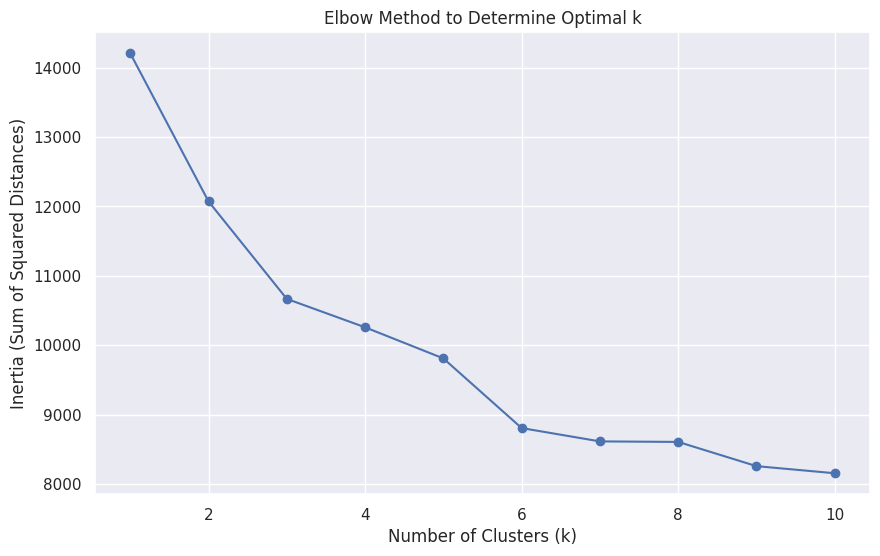

In [156]:
def elbow_method(data, k_range):
    """
    Determine the optimal number of clusters using the elbow method.

    Parameters:
    - data: The dataset to cluster (e.g., scaled time-series matrix).
    - k_range: A range of possible cluster numbers to evaluate.

    Returns:
    - inertia_scores: A list of inertia scores for each value of k.
    """
    inertia_scores = []

    # Compute KMeans for each value of k
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia_scores.append(kmeans.inertia_)  # Append the inertia (sum of squared distances)

    # Plot the inertia scores against k
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia_scores, marker='o')
    plt.title('Elbow Method to Determine Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Sum of Squared Distances)')
    plt.grid()
    plt.show()

    return inertia_scores

# Example usage
k_range = range(1, 11)  # Test k from 1 to 10
inertia_scores = elbow_method(time_series_scaled, k_range)

In [165]:
# Choose optimal number of clusters (based on silhouette score or elbow method)

elbow_method_optimal_k = 3
print(f"Optimal number of clusters based on elbow method: {elbow_method_optimal_k}")
# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=elbow_method_optimal_k, random_state=42)
station_clusters = kmeans.fit_predict(time_series_scaled)

# Add cluster labels to stations
clustered_stations = pd.DataFrame({
    'station_id': time_series_matrix.index,
    'cluster': station_clusters
})

Optimal number of clusters based on elbow method: 3


In [166]:
clustered_stations.cluster.value_counts()

cluster
2    435
0     91
1     66
Name: count, dtype: int64

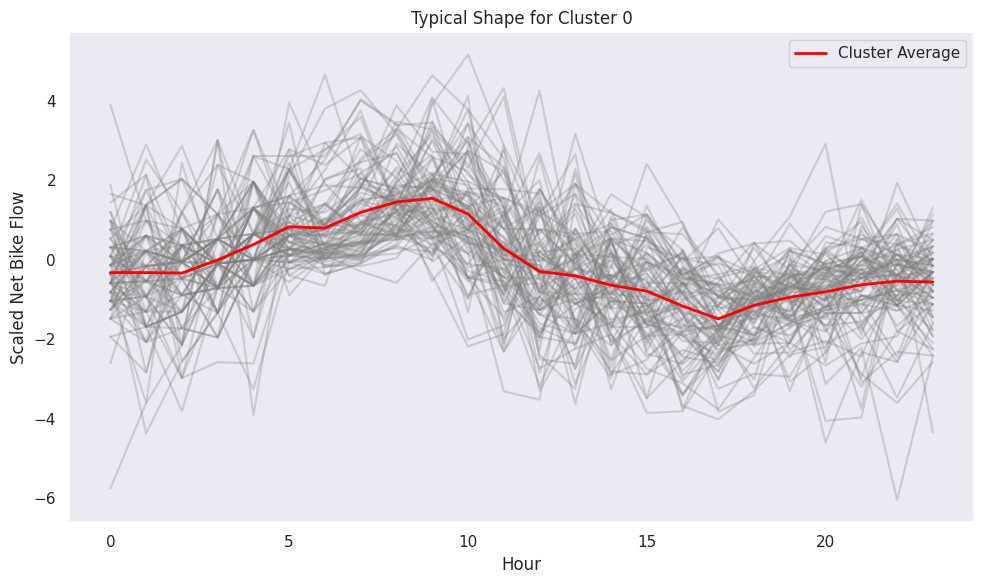

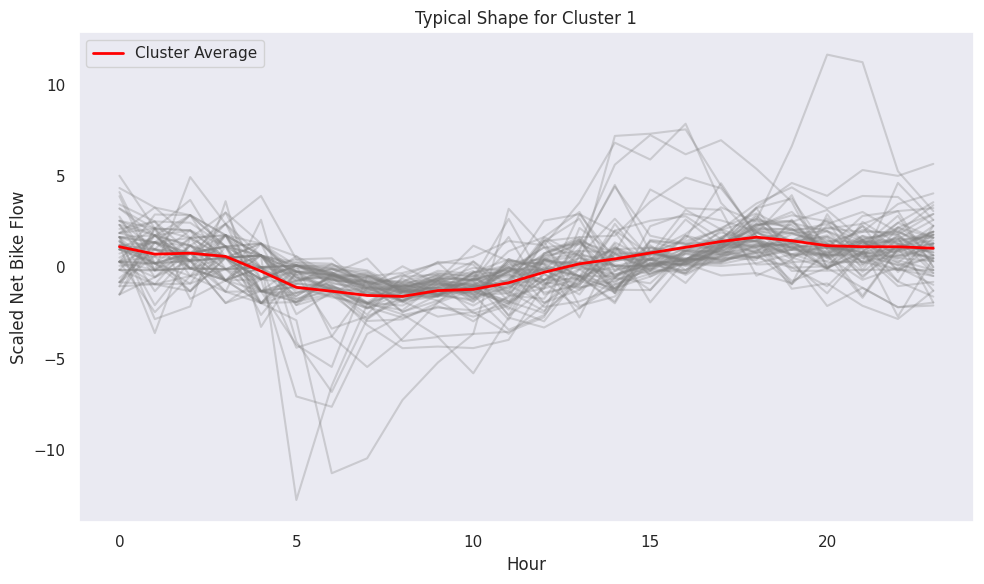

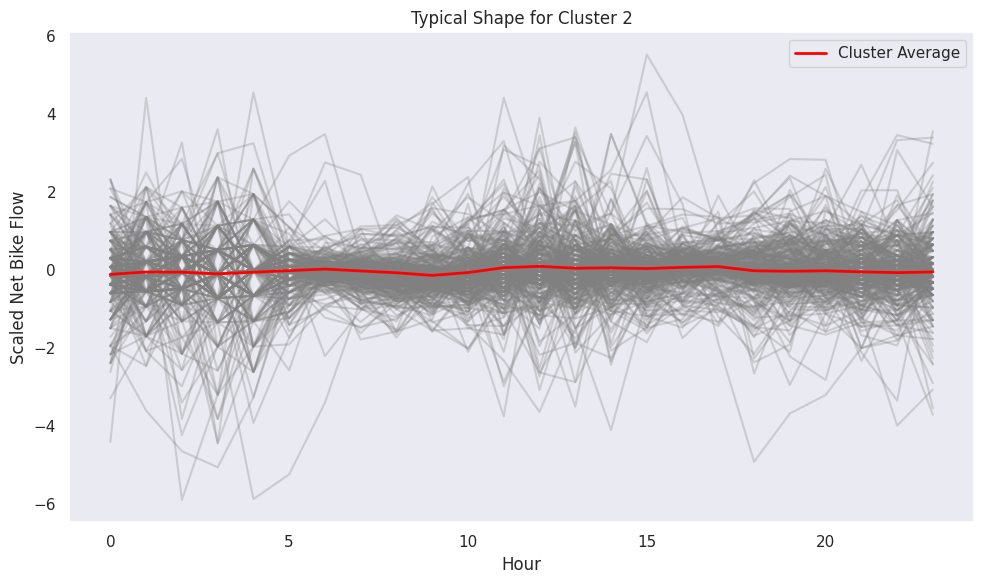

In [169]:
# Add cluster labels to the scaled data for visualization
clustered_data = pd.DataFrame(time_series_scaled, index=time_series_matrix.index)
clustered_data['cluster'] = station_clusters

# Plot the average pattern and all others for each cluster
for cluster_id in sorted(clustered_data['cluster'].unique()):
    cluster_members = clustered_data[clustered_data['cluster'] == cluster_id].drop(columns=['cluster'])

    # Calculate the average pattern for the cluster
    cluster_average = cluster_members.mean(axis=0)

    plt.figure(figsize=(10, 6))

    # Plot all members in grey
    for _, member in cluster_members.iterrows():
        plt.plot(member.values, color='grey', alpha=0.3)

    # Plot the average in red
    plt.plot(cluster_average.values, color='red', label='Cluster Average', linewidth=2)

    # Add labels and title
    plt.title(f'Typical Shape for Cluster {cluster_id}')
    plt.xlabel('Hour')
    plt.ylabel('Scaled Net Bike Flow')
    plt.legend()
    plt.tight_layout()
    plt.show()

## **Others**

In [ ]:
!jupyter nbconvert --to html Citibike_Case_Study.ipynb


[NbConvertApp] Converting notebook Citibike_Case_Study.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 1666682 bytes to Citibike_Case_Study.html


In [2]:
!jupyter nbconvert --to html --no-input Citibike_Case_Study.ipynb


[NbConvertApp] Converting notebook Citibike_Case_Study.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 11 image(s).
[NbConvertApp] Writing 3183505 bytes to Citibike_Case_Study.html
